### Intro

Chiamo "sistema" una rete di Vogels & Abbott avente determinati parametri. Ogni sistema ha un certo numero (in questo caso 10) di realizzazioni che corrispondono alle realizzazioni delle matrici di connessione e dei valori di inizializzazione del potenziale di membrana. 

La simulazione e' stata svolta in maniera parallela per 2000 sistemi indipendenti, per un totale di 2 milioni di neuroni.

Per ciascuna realizzazione vengono estratte certe quantita', come l'attivita' media e il coefficiente di variazione dell'ISI.

In [1]:
import numpy as np 
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.style.use("./style.mplstyle")

pd.set_option('display.max_colwidth', 100)
import seaborn as sns;sns.set()

# Last was spinnaker10?
raw_df = pd.read_csv("A.csv")


raw_df.exc_conn_p *= 100
raw_df.inh_conn_p *= 100

print(f"Number of simulated systems:{len(np.unique(raw_df.sys_id))}")
print(f"Excitatory connectivities are:\n{np.unique(raw_df.exc_conn_p)}")
print(f"Timesteps are:\n{np.unique(raw_df.timestep)}")

Number of simulated systems:1350
Excitatory connectivities are:
[ 1.          2.07142857  3.14285714  4.21428571  5.28571429  6.35714286
  7.42857143  8.5         9.57142857 10.64285714 11.71428571 12.78571429
 13.85714286 14.92857143 16.        ]
Timesteps are:
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


### Preprocessing

In [10]:
from local_utils import string_to_array

df= pd.DataFrame()
raw_df['id'] = raw_df.sys_id.apply(str) + "_" + raw_df['pop']
raw_df = raw_df.set_index("id")

df['id'] = np.unique(raw_df.index.values)
df['pop_type'] = df['id'].apply( lambda x: x[-3:])

df = df.set_index('id')

funcs = np.unique(raw_df.func)

time_series_funcs = []
for func in funcs:
    df[func] = raw_df[ raw_df.func == func].extraction
    try:
        df[func] = df[func].astype(float)
    except Exception as e:
        time_series_funcs.append(func)

for column in ['timestep', 'exc_conn_p']:
    df[column] = raw_df[raw_df.func == funcs[0]][column]
    
    
df['is_asleep'] = (df.avg_activity < 2.0).astype(int)

df.rate_of_active_avg = df.rate_of_active_avg.fillna(0)
df.rate_of_active_std = df.rate_of_active_std.fillna(0)

#### Time series
time_series = dict()

for ts_func in time_series_funcs:
    time_series[ts_func] = dict()

    for id, row in df.iterrows():
        try:
            time_series[ts_func][id] = string_to_array(df.loc[(id, ts_func)])
        except AttributeError:
            pass
display(time_series.keys())
df = df[df.pop_type =='inh']
df = df.sort_values("timestep")

dict_keys(['PSD', 'v_regular_binned'])

# Sustained activity

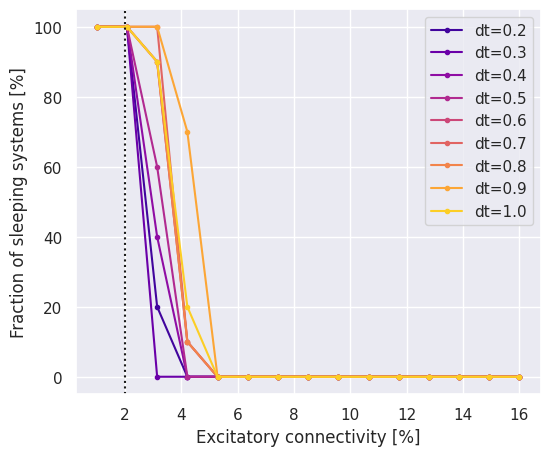

In [3]:
timesteps_to_plot = np.sort(df.timestep.unique()) #[0.1, 0.2, 0.4, 0.6, 0.8, 1.0] #

colors = sns.color_palette('plasma', len(timesteps_to_plot))
for dt ,c in zip(timesteps_to_plot, colors):
    subdf = df[df.timestep == dt]
    grouped = subdf.groupby('exc_conn_p')[['exc_conn_p', 'is_asleep']].mean()

    plt.plot(grouped.exc_conn_p, grouped.is_asleep*100,  marker=".", label=f"dt={dt}", color=c)

plt.axvline(2, color="k", ls=":")
plt.ylabel('Fraction of sleeping systems [%]')
plt.xlabel('Excitatory connectivity [%]')
plt.legend();

La figura mostra il numero di realizzazioni che non vengono attivate dallo stimolo talamico.
A parita' di connettivita' eccitatoria, i sistemi con un passo di integrazione piu' grande tendono ad essere meno attivabili, mostrando un numero piu' alto di realizzazioni inattive.

# Average activity

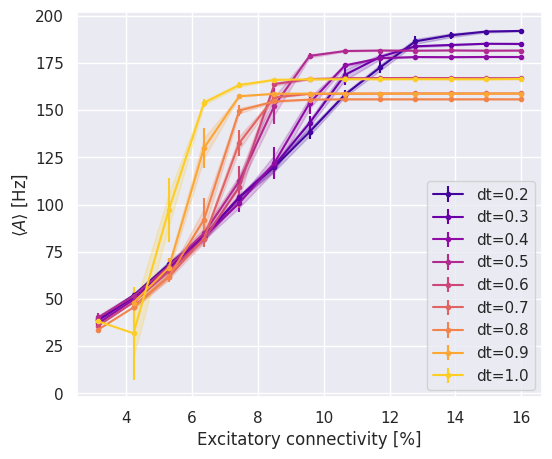

In [4]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep==dt)&(~df.is_asleep)].groupby('exc_conn_p')
    
    plt.errorbar(subdf.exc_conn_p.mean(), subdf.avg_activity.mean(), subdf.avg_activity.std(),
                  marker=".", ls="-",   label=f"dt={dt}", color=c)
    plt.fill_between(subdf.exc_conn_p.mean(), 
                     subdf.avg_activity.mean() - 0.5*subdf.avg_activity.std(), 
                     subdf.avg_activity.mean() + 0.5*subdf.avg_activity.std(), color=c, alpha=0.2)
plt.ylabel(r"$\langle A \rangle$ [Hz]")
plt.xlabel("Excitatory connectivity [%]")
plt.legend();

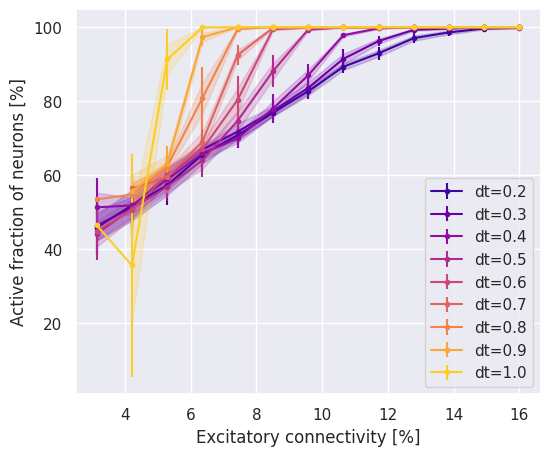

In [5]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep==dt)&(~df.is_asleep)].groupby('exc_conn_p')
    
    plt.errorbar(subdf.exc_conn_p.mean(), 100*subdf.active_fraction.mean(), 100*subdf.active_fraction.std(),
                  marker=".", ls="-",   label=f"dt={dt}", color=c)
    plt.fill_between(subdf.exc_conn_p.mean(), 
                     100*subdf.active_fraction.mean() - 0.5*100*subdf.active_fraction.std(), 
                     100*subdf.active_fraction.mean() + 0.5*100*subdf.active_fraction.std(), color=c, alpha=0.2)
plt.ylabel("Active fraction of neurons [%]")
plt.xlabel("Excitatory connectivity [%]")
plt.legend();

Si nota che oltre una connettivita' eccitatoria $p_{sat}$ i valori di attivita' media e frazione attiva (piu' di ideci spikes nell'intero intervallo di simulazione) saturano contemporaneamente ad un valore $A_{sat}(dt)$ e 1.

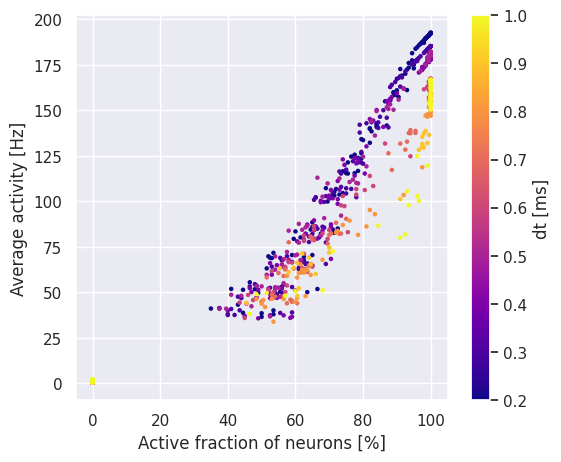

In [6]:
plt.scatter(100*df.active_fraction, df.avg_activity, c=df.timestep, cmap="plasma", s=5)
plt.colorbar(label='dt [ms]')
plt.xlabel("Active fraction of neurons [%]")
plt.ylabel("Average activity [Hz]");

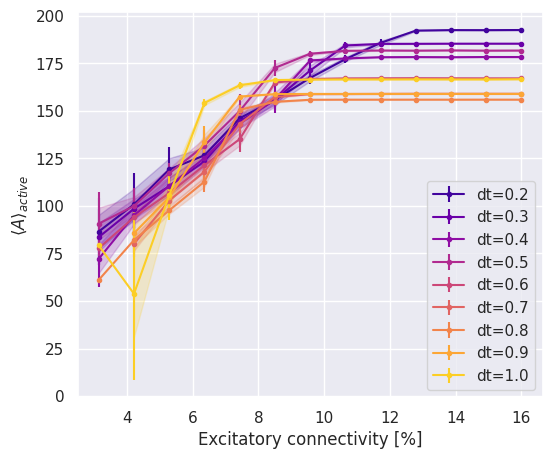

In [7]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep==dt)&(~df.is_asleep)].groupby('exc_conn_p')
    
    plt.errorbar(subdf.exc_conn_p.mean(), subdf.rate_of_active_avg.mean(), subdf.rate_of_active_avg.std(),
                  marker=".", ls="-",   label=f"dt={dt}", color=c)
    plt.fill_between(subdf.exc_conn_p.mean(), 
                     subdf.rate_of_active_avg.mean() - 0.5*subdf.rate_of_active_avg.std(), 
                     subdf.rate_of_active_avg.mean() + 0.5*subdf.rate_of_active_avg.std(), color=c, alpha=0.2)
plt.ylabel(r"$\langle A\rangle_{active}$")
plt.xlabel("Excitatory connectivity [%]")
plt.legend();

## Stima della connettivita' e attivita' di saturazione

considero saturo un sistema che ha oltre il 99% di neuroni attivi

In [8]:
df["is_saturated"] = (df.v_divergent >= 0.99)

psat_dict = dict()
asat_dict = dict()

for dt in df.timestep.unique():
    subdf = df[(df.timestep == dt)&(df.is_saturated)]

    # Stimo primo record saturato
    first = subdf.sort_values('exc_conn_p').index[0]
    
    psat_dict[dt] = subdf.loc[first].exc_conn_p
    asat_dict[dt] = subdf.loc[first].avg_activity

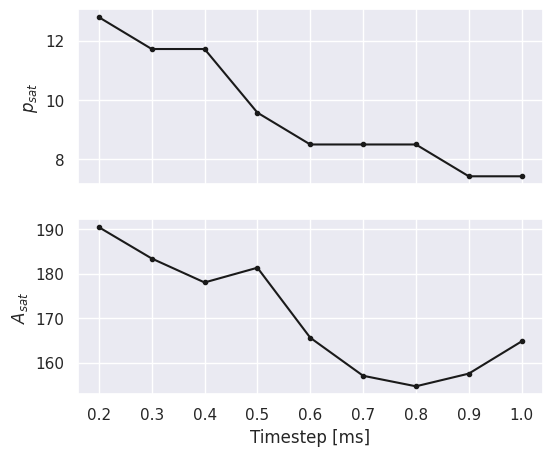

In [9]:
fig, (axp, axa) = plt.subplots(2,1,sharex=True)

axp.plot(psat_dict.keys(), psat_dict.values(),  marker=".", color="k")
axp.set_ylabel(r"$p_{sat}$")

axa.plot(asat_dict.keys(), asat_dict.values(), marker=".", color="k")
axa.set_ylabel(r"$A_{sat}$")
axa.set_xlabel("Timestep [ms]");


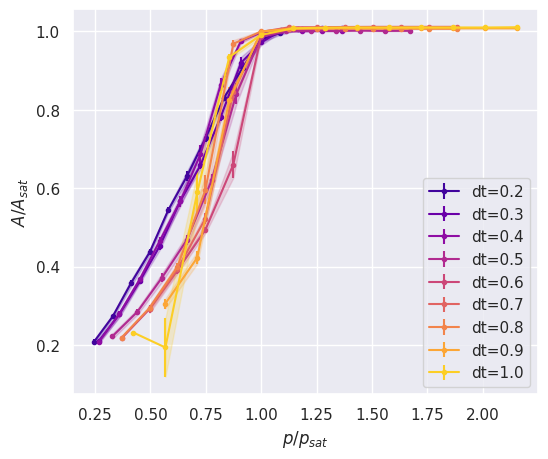

In [10]:
from sklearn.linear_model import LinearRegression
timesteps_to_plot = np.sort(df.timestep.unique())

colors = sns.color_palette('plasma', len(timesteps_to_plot))
for dt ,c in zip(timesteps_to_plot, colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)]

    avgs = subdf.groupby('exc_conn_p')[['exc_conn_p', 'avg_activity']].mean()
    stds = subdf.groupby('exc_conn_p')[['exc_conn_p', 'avg_activity']].std()

    # model = LinearRegression()
    # model.fit(subdf.exc_conn_p.values.reshape(-1,1), subdf.extraction.values.reshape(-1,1))
    # xx = np.linspace(np.min(subdf.exc_conn_p), np.max(subdf.exc_conn_p), 2)
    # plt.plot(xx, model.predict(xx[:, None]), color=c)

    plt.errorbar(avgs.exc_conn_p/psat_dict[dt], avgs.avg_activity/asat_dict[dt], 0.5*stds.avg_activity/asat_dict[dt],  marker=".", ls="-",   label=f"dt={dt}", color=c)
    plt.fill_between(avgs.exc_conn_p/psat_dict[dt], 
                     (avgs.avg_activity - 0.5*stds.avg_activity)/asat_dict[dt], 
                     (avgs.avg_activity + 0.5*stds.avg_activity)/asat_dict[dt], color=c, alpha=0.2)

plt.ylabel(r'$A/A_{sat}$')
plt.xlabel(r'$p/p_{sat}$')
plt.legend();

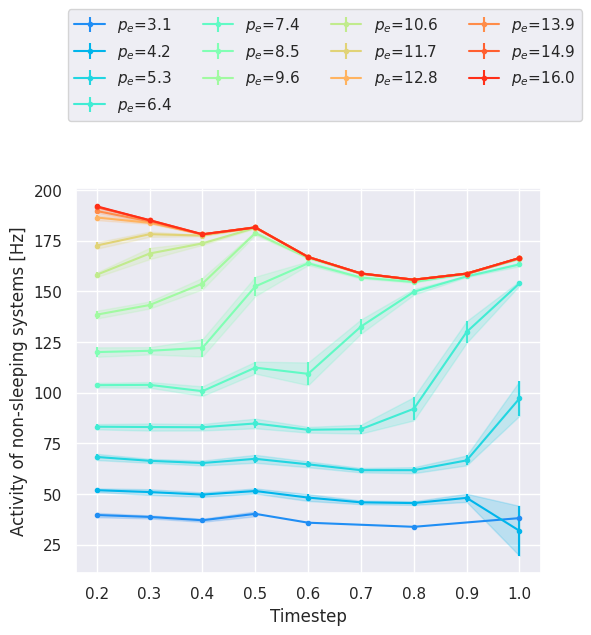

In [11]:
pexc_to_plot = np.sort(df.exc_conn_p.unique())

colors = sns.color_palette('rainbow', len(pexc_to_plot))
fig, ax = plt.subplots()

for pexc, c in zip(pexc_to_plot, colors):
    subdf = df[(df.exc_conn_p == pexc)&(~df.is_asleep)]

    if len(subdf) == 0:
        continue

    avgs = subdf.groupby('timestep')[['timestep', 'avg_activity']].mean()
    stds = subdf.groupby('timestep')[['timestep', 'avg_activity']].std()

    plt.errorbar(avgs.timestep, avgs.avg_activity, 0.5*stds.avg_activity,  marker=".", ls="-",   label=f"$p_e$={pexc:.1f}", color=c)
    plt.fill_between(avgs.timestep, 
                     avgs.avg_activity - 0.5*stds.avg_activity, 
                     avgs.avg_activity + 0.5*stds.avg_activity, color=c, alpha=0.2)

plt.ylabel('Activity of non-sleeping systems [Hz]')
plt.xlabel('Timestep')
fig.legend(loc='lower left', bbox_to_anchor=(0.1,1), ncols=4);

Stessa cosa vista al contrario: $\langle A(t) \rangle$ in funzione del timestep per ogni connettivita'. A bassa connettivita' un timestep piu' alto e' piu' coerente con il 'valore vero' di $\langle A(t) \rangle$, quello per $dt \rightarrow 0$.

# Satistiche dei firing rate

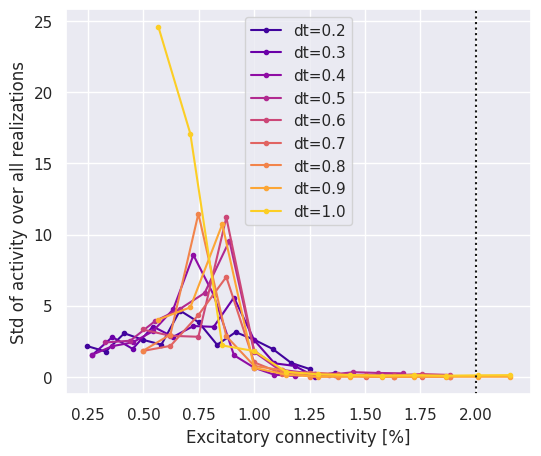

In [12]:
from sklearn.linear_model import LinearRegression
timesteps_to_plot = np.sort(df.timestep.unique())

colors = sns.color_palette('plasma', len(timesteps_to_plot))
for dt ,c in zip(timesteps_to_plot, colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)]

    avgs = subdf.groupby('exc_conn_p')[['exc_conn_p', 'avg_activity']].mean()
    stds = subdf.groupby('exc_conn_p')[['exc_conn_p', 'avg_activity']].std()
    
    plt.plot(avgs.exc_conn_p/psat_dict[dt], stds.avg_activity,  marker=".", ls="-",   label=f"dt={dt}", color=c)


plt.axvline(2, color="k", ls=":")
plt.ylabel('Std of activity over all realizations')
plt.xlabel('Excitatory connectivity [%]')
plt.legend();

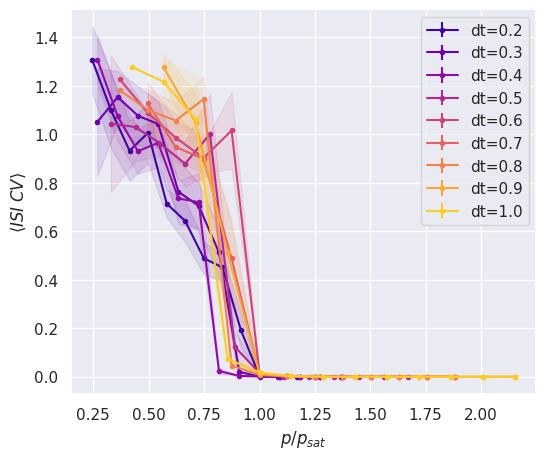

In [13]:
from sklearn.linear_model import LinearRegression
timesteps_to_plot = np.sort(df.timestep.unique())

colors = sns.color_palette('plasma', len(timesteps_to_plot))
for dt ,c in zip(timesteps_to_plot, colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)]

    subdf = subdf.dropna()
    avgs = subdf.groupby('exc_conn_p')[['exc_conn_p', 'isi_cv_avg']].mean()
    stds = subdf.groupby('exc_conn_p')[['exc_conn_p', 'isi_cv_avg']].std()

    plt.errorbar(avgs.exc_conn_p/psat_dict[dt], avgs.isi_cv_avg, .0*stds.isi_cv_avg,  marker=".", ls="-",   label=f"dt={dt}", color=c)
    plt.fill_between(avgs.exc_conn_p/psat_dict[dt], 
                     avgs.isi_cv_avg - 0.5*stds.isi_cv_avg, 
                     avgs.isi_cv_avg + 0.5*stds.isi_cv_avg, color=c, alpha=0.1)

plt.ylabel(r'$\langle ISI\;CV \rangle$')
plt.xlabel(r'$p/p_{sat}$')
plt.legend()

L' ISI CV decresce al decrescere della connettivita'. Reti troppo connesse mostrano un firing piu' regolare rispetto al 'valore vero'. Una cosa curiosa: prima di discendere ad un firing forzosamente regolare le reti mostrano un picco di irregolarita'. Questo picco avviene subito prima che la rete saturi ad un regime di alta attivita'. 

Ad ogni modo, e' piu corretto dire che il picco in $CV$ si verifichi per una certa connettivita' di saturazione (presumibilmente la stessa $p_{sat}$ di prima) perche' $\langle A \rangle (p_{sat})$ non e' uguale per ogni dt. 

Text(0.5, 0, '$p/p_{sat}$')

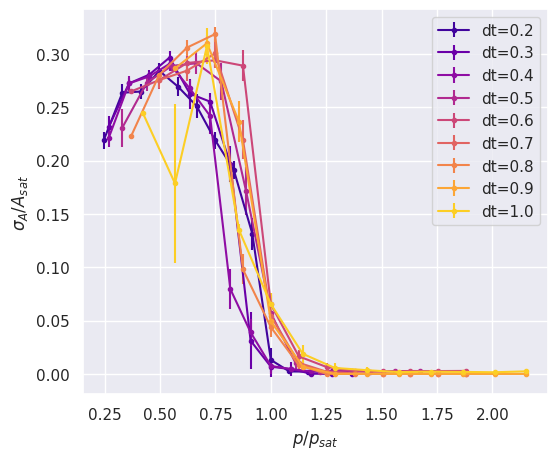

In [14]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)].groupby('exc_conn_p')
    plt.errorbar(subdf.exc_conn_p.mean()/psat_dict[dt], subdf.rate_of_active_std.mean()/asat_dict[dt], 0.5*subdf.rate_of_active_std.std()/asat_dict[dt], 
                 color=c, marker='.', label=f"dt={dt:.1f}")
plt.legend()

plt.ylabel(r"$\sigma_{A}/A_{sat}$")
plt.xlabel(r"$p/p_{sat}$")

### Activity vs ISI|CV

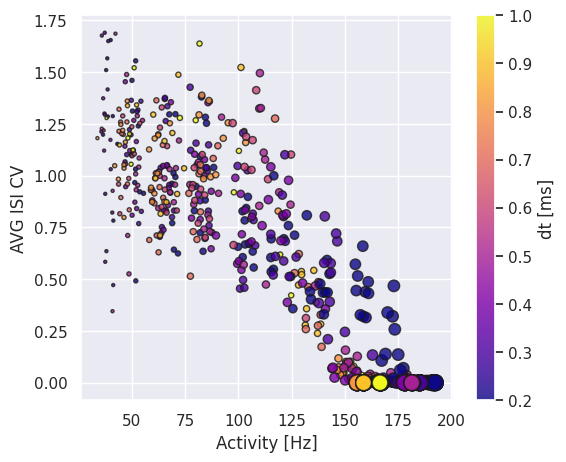

In [15]:
pexc_to_plot = np.sort(np.unique(df.exc_conn_p))
fig, ax = plt.subplots()

for pexc in pexc_to_plot:
    subdf = df[df.exc_conn_p == pexc]
    mappable = ax.scatter(subdf.avg_activity, subdf.isi_cv_avg, 
                c=subdf.timestep,
                s=0.5*(pexc)**2,
                edgecolor="k",
                alpha=0.8,
                cmap="plasma",label=f"$p_e$={pexc:.1f}%")
fig.colorbar(mappable, label="dt [ms]")
ax.set_xlabel("Activity [Hz]");
ax.set_ylabel("AVG ISI CV");

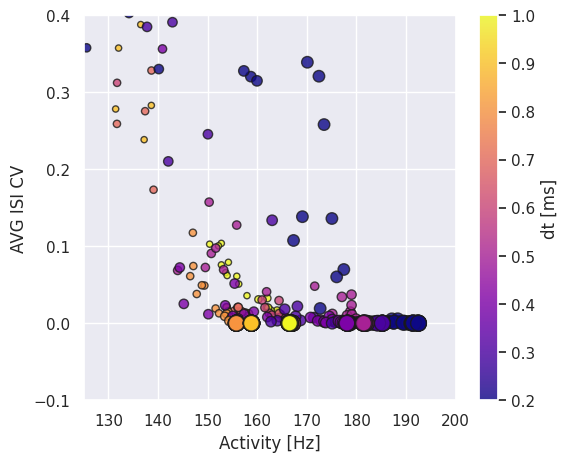

In [16]:
ax.set_xlim(125, 200)
ax.set_ylim(-0.1, 0.4)
display(fig)

## ISI stats

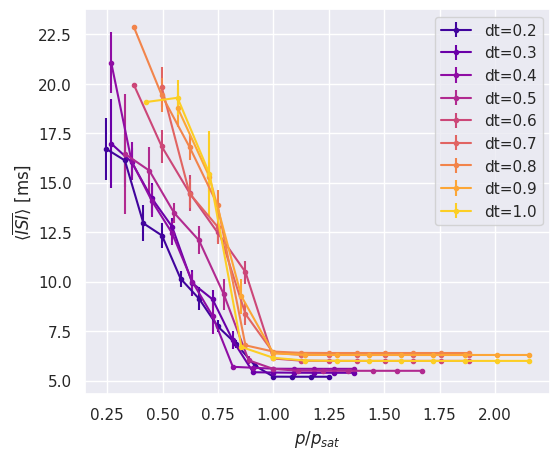

In [17]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)].groupby('exc_conn_p')
    plt.errorbar(subdf.exc_conn_p.mean()/psat_dict[dt], subdf.isi_mean_avg.mean(), 0.5*subdf.isi_mean_avg.std(), 
                 color=c, marker='.', label=f"dt={dt:.1f}")
plt.xlabel(r"$p/p_{sat}$")
plt.ylabel(r"$\langle \overline{ISI} \rangle$ [ms]")
plt.legend();

Text(0, 0.5, '$\\langle \\sigma_t(ISI) \\rangle$ [ms]')

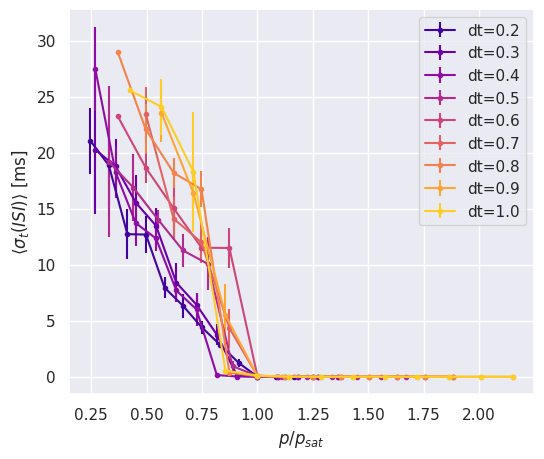

In [18]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)].groupby('exc_conn_p')
    plt.errorbar(subdf.exc_conn_p.mean()/psat_dict[dt], subdf.isi_tstd_avg.mean(), 0.5*subdf.isi_tstd_avg
                 .std(), 
                 color=c, marker='.', label=f"dt={dt:.1f}")
plt.legend()
plt.xlabel(r"$p/p_{sat}$")
plt.ylabel(r"$\langle \sigma_t(ISI) \rangle$ [ms]")

### Statistiche dei potenziali di membrana

Supponendo la distribuzione dei potenziali si strazionaria (TODO), questa si puo' scrivere come una mixture distribution:

$$\rho(V, t) = \rho(V) = \alpha \delta(v - v_{reset}) + (1-\alpha)\rho_{regular}(V)$$

in cui $\alpha$ rappresenta la frazione divergente dei potenziali.

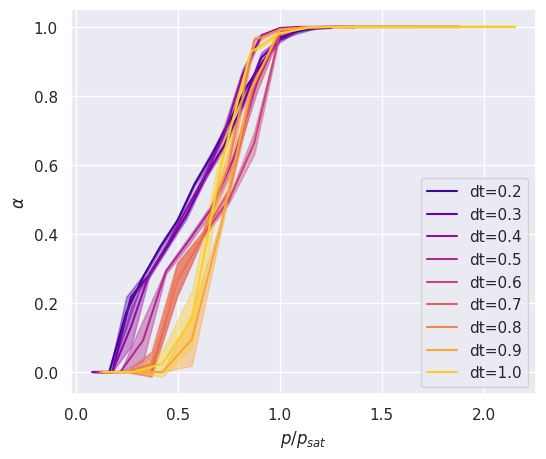

In [19]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[df.timestep == dt].groupby("exc_conn_p")
    plt.plot(subdf.exc_conn_p.mean()/psat_dict[dt], subdf.v_divergent.mean(), label=f"dt={dt}", ls="-", marker="",color=c)
    plt.fill_between(subdf.exc_conn_p.mean()/psat_dict[dt], 
                      subdf.v_divergent.mean() - 0.5*subdf.v_divergent.std(), 
                      subdf.v_divergent.mean() + 0.5*subdf.v_divergent.std(), color=c, alpha=0.4)
plt.ylabel(r"$\alpha$")
plt.xlabel(r"$p/p_{sat}$")
plt.legend();

In [20]:
# subdf = df[(~df.is_saturated)&(~df.is_asleep)]
# fig, axes = plt.subplots(2,2)
# p_to_plot = np.sort(subdf.exc_conn_p.unique())[[0,1,2,3]]
# print(p_to_plot)
# for p, ax in zip(p_to_plot, axes.flatten()):
#     sub_subdf = subdf[subdf.exc_conn_p==p]
#     index = sub_subdf.

# Statistiche delle conduttanze sinaptiche

Se $g_i(t)$ e' la conduttanza dell' i-esimo neurone in funzione del tempo:
$$\langle \overline{g} \rangle = \frac{1}{N}\sum_i \int_{T-\Delta t}^{T}g_i(t)dt$$

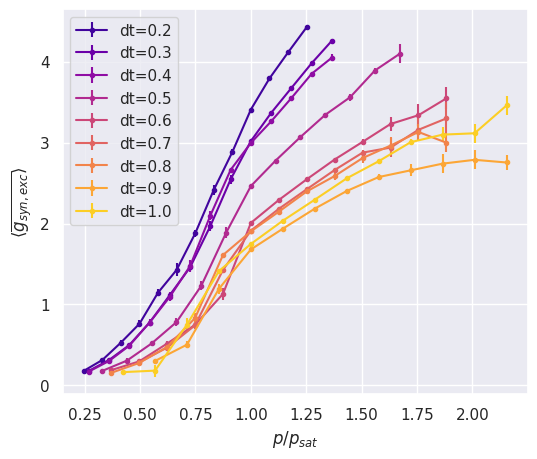

In [21]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)].groupby('exc_conn_p')
    plt.errorbar(subdf.exc_conn_p.mean()/psat_dict[dt], subdf.gsyn_exc_avg_mean.mean(), 0.5*subdf.gsyn_exc_avg_mean.std(), 
                 color=c, marker='.', label=f"dt={dt:.1f}")
plt.legend()
plt.xlabel(r"$p/p_{sat}$")
plt.ylabel(r"$\langle \overline{g_{syn, exc}} \rangle$");

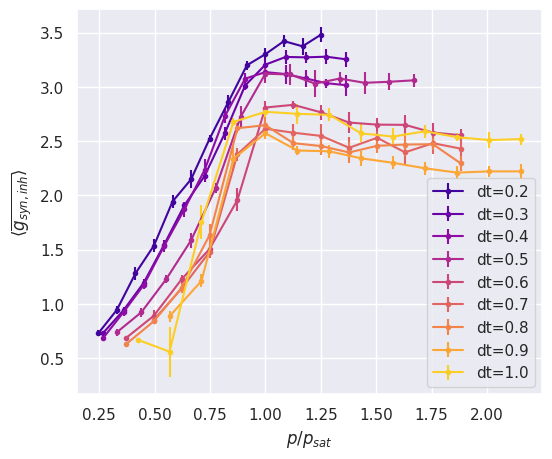

In [22]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)].groupby('exc_conn_p')
    plt.errorbar(subdf.exc_conn_p.mean()/psat_dict[dt], subdf.gsyn_inh_avg_mean.mean(), 0.5*subdf.gsyn_inh_avg_mean.std(), 
                 color=c, marker='.', label=f"dt={dt:.1f}")
plt.legend()
plt.xlabel(r"$p/p_{sat}$")
plt.ylabel(r"$\langle \overline{g_{syn, inh}} \rangle$");

# Statistiche spettrali


Sia l'attivita' di spiking definita per il neurone i-esimo da $a_i(t) = \sum_m \delta(t - t_m)$, dove $t_m$ indica il tempo della m-esima spike.

Sia $a_\Delta(t)$ la attivita' media a tempi brevi definita da:

$$a_\Delta(t) = \frac{1}{N} \sum_i \int_t^{(t+\Delta)} a_i(t)$$

E' possibile trovare la trasformata $\tilde{a}(f) $ e dunque la densita' spettrale di potenza $S(f) = |\tilde{a}(f)|^2$. 

Definito un binning in frequenza $[f_1, f_2, \dots , f_n]$ si definisce la densita' binnata come:

$$S_k = \int_{f_k}^{f_{k+1}} S(f) df$$

e l'entropia

$$H = \sum S_k \log(S_k)$$




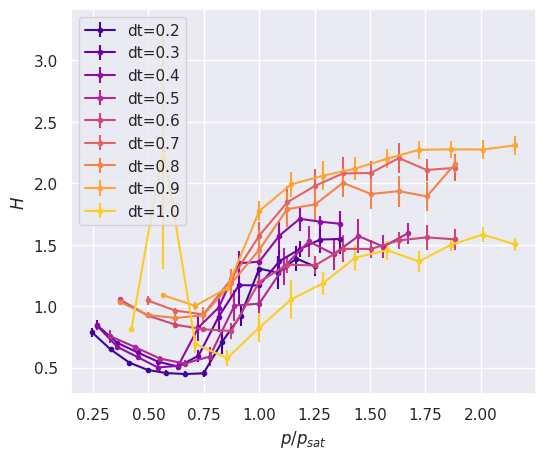

In [23]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)].groupby('exc_conn_p')
    plt.errorbar(subdf.exc_conn_p.mean()/psat_dict[dt], subdf.spectral_entropy.mean(), 0.5*subdf.spectral_entropy.std(), 
                 color=c, marker='.', label=f"dt={dt:.1f}")
plt.legend()
plt.xlabel(r"$p/p_{sat}$")
plt.ylabel(r"$H$");

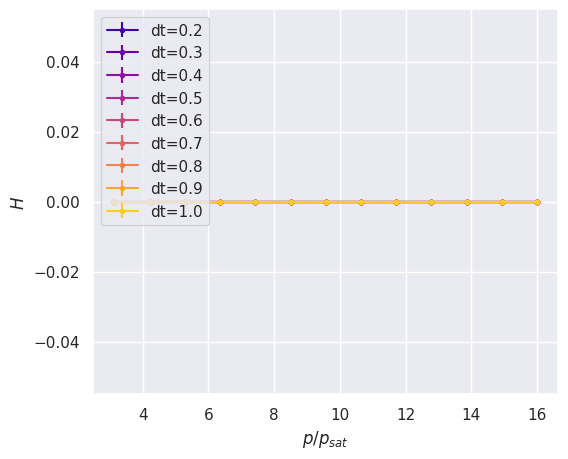

In [24]:
colors = sns.color_palette('plasma', len(df.timestep.unique()))
for dt, c in zip(df.timestep.unique(), colors):
    subdf = df[(df.timestep == dt)&(~df.is_asleep)].groupby('exc_conn_p')
    plt.errorbar(subdf.exc_conn_p.mean(), subdf.spectral_mode.mean(), 0.5*subdf.spectral_mode.std(), 
                 color=c, marker='.', label=f"dt={dt:.1f}")
plt.legend()
plt.xlabel(r"$p/p_{sat}$")
plt.ylabel(r"$H$");

## Rappresentazione UMAP

Visualizzo le similarita' tra gli esiti delle realizzazioni delle reti tramite un ambedding UMAP. Ogni realizzazione e' un punto in uno spazio ad alta dimensionalita'.

In [25]:
print(f"Space has dimension {len(df.drop(columns=['timestep', 'exc_conn_p', 'pop_type', 'v_regular_binned', 'is_asleep', 'is_saturated']).columns)}")
print(f"Dimensions represent {list(df.drop(columns=['timestep', 'exc_conn_p', 'pop_type', 'v_regular_binned', 'is_asleep', 'is_saturated']).columns)}")

Space has dimension 12
Dimensions represent ['active_fraction', 'avg_activity', 'gsyn_exc_avg_mean', 'gsyn_inh_avg_mean', 'isi_cv_avg', 'isi_mean_avg', 'isi_tstd_avg', 'rate_of_active_avg', 'rate_of_active_std', 'spectral_entropy', 'spectral_mode', 'v_divergent']


In [26]:
from umap import UMAP
reducer = UMAP(n_neighbors=30, min_dist=1.0)

/home/bbpnrsoa/djanloovenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from sklearn.preprocessing import MinMaxScaler
subdf = df.dropna()
subdf= subdf[~subdf.is_asleep.astype(bool)]
subdf = subdf[list(raw_df.func.unique()) + ['timestep', 'exc_conn_p']]
subdf = subdf.drop(columns=['v_regular_binned', ])
X = subdf.drop(columns=['timestep', 'exc_conn_p']).values
print(X.shape)
X = MinMaxScaler().fit_transform(X)

(1096, 12)


In [28]:
embedding = reducer.fit_transform(X)

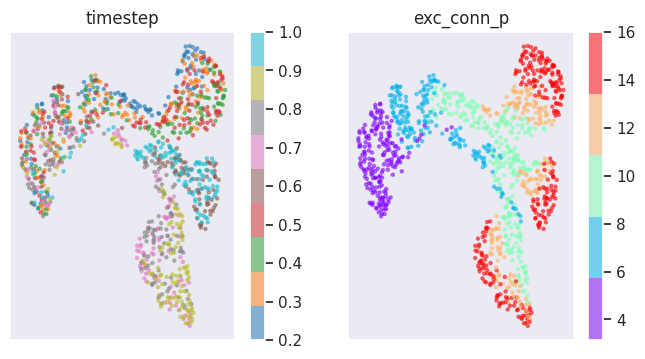

In [29]:
import matplotlib
fig, axes = plt.subplots(1,2, figsize= (8,4))

cmap1 = matplotlib.colormaps["tab10"].resampled(len(df.timestep.unique()))
cmap2 = matplotlib.colormaps["rainbow"].resampled(len(df.exc_conn_p.unique())/3)

for func,cmap, ax in zip(['timestep', 'exc_conn_p'], [cmap1,cmap2], axes):
    ax.set_title(func)
    mappable=ax.scatter(*(embedding.T), c=subdf[func], s=5,alpha=0.5, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(mappable=mappable)

Da questa si vede che i dati hanno una struttura nello spazio ad alta dimensionalita', in particolare si vede che entro una connettivit'a del 6% tutti gli integratori sono circa simili. Per una connettivita' piu' alta invece i timesteps 0.2, 0.3, 0.4, 0.5 hanno esiti simili, come 0.7,0.8,0.9 . Inaspettatamente, il timestep 1.0 e' piu' simile al timestep 0.6.

/home/bbpnrsoa/djanloovenv/lib/python3.8/site-packages/matplotlib/colorbar.py:1243: RuntimeWarning: divide by zero encountered in true_divide
  y = y / (self._boundaries[self._inside][-1] -
/home/bbpnrsoa/djanloovenv/lib/python3.8/site-packages/matplotlib/colorbar.py:1243: RuntimeWarning: invalid value encountered in true_divide
  y = y / (self._boundaries[self._inside][-1] -
/tmp/ipykernel_24848/911331163.py:29: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.colorbar(mappable)


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

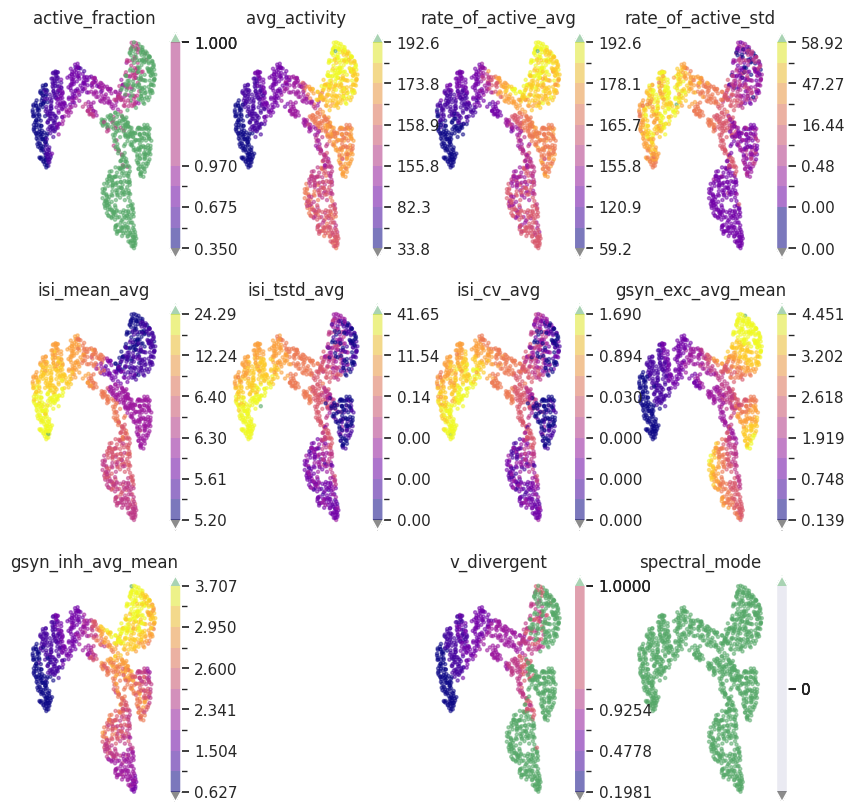

In [30]:
import matplotlib.colors as mcolors
from matplotlib import cm

n_bands = 10
colors = ['k'] + list(matplotlib.colormaps["plasma"].resampled(n_bands).colors) + ['g']

funcdesc = dict(avg_activity=r"$\langle A \rangle_{all}$",
                active_fraction=f"Frazione attiva",
                rate_of_active_avg="Media sulla popolazione dei rate dei neuroni attivi",
                rate_of_active_std="Varianza sulla popolazione dei rate dei neuroni attivi",
                avg_isi_cv="Media sugli attivi del coefficiente di variazione dell' ISI",
                isi_active_avg_mean="Media sugli attivi della media temporale dell'ISI",
                isi_active_avg_tstd="Media sugli attivi della varianza temporale dell'ISI")

fig, axes = plt.subplots(3, 4, figsize=(10, 10))
for ax in axes.flatten():
    ax.axis('off')

for func, ax in zip(raw_df.func.unique(), axes.flatten()):
    if func == 'v_regular_binned' or func == 'phase_invariant_average':
        continue
    title = funcdesc.get(func, func)
    ax.set_title(func)
    levels = np.quantile(subdf[func].values, np.linspace(0,1,n_bands + 1))
    cmap, norm = mcolors.from_levels_and_colors(levels, colors, extend="both")
    mappable= ax.scatter(*(embedding.T), c=subdf[func], s=5,alpha=0.5, cmap=cmap, norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(mappable)
    # plt.figure()
    # plt.hist(subdf[func])
    # plt.title(func)

Questa figura mostra come i valori di ciascuna feature sono distribuiti sul manifold.

In [ ]:
# n_bands = 10
# colors = ['k'] + list(matplotlib.colormaps["plasma"].resampled(n_bands).colors) + ['g']


# t, p = np.sort(subdf.timestep.unique()), np.sort(subdf.exc_conn_p.unique())
# T, P = np.meshgrid(t, p)
# Z = np.zeros((len(t), len(p)))

# print(len(p), len(t))

# for func in raw_df.func.unique():
#     if func != 'v_regular_binned':
#         plt.figure()
#         for i in range(len(t)):
#             for j in range(len(p)):

#                 mask = (df.timestep==t[i])&(df.exc_conn_p==p[j])
#                 if np.sum(mask) == 0:
#                     print(f"No values found for {func} in p={p[j]}, t={t[i]}")
#                 values = df.loc[mask][func]
#                 values = values[~np.isnan(values)]
#                 Z[i,j] = np.mean(values)


#         plt.contourf(T,P,Z.T, cmap='viridis')

#         plt.xlabel("Timestep [ms]")
#         plt.ylabel("Ecitatory connectivity [%]")

#         plt.colorbar(label=funcdesc.get(func, func))

# Phase-mathcing average

TODO

In [ ]:
# id = df.index[np.random.randint(len(df))]

# plt.plot( time_series['phase_invariant_average'][id], marker='.')
# plt.title(f"p = {df.loc[id].exc_conn_p:.2f}, dt={df.loc[id].timestep:.1f}")

# Phase diagram

In [ ]:
Z = np.zeros((len(df.timestep.unique()), len(df.exc_conn_p.unique())))
X = np.sort(df.timestep.unique())
Y = np.sort(df.exc_conn_p.unique())

X, Y = np.meshgrid(X,Y)
cmap = matplotlib.colormaps['plasma'].resampled(3)

for i, dt in enumerate(np.sort(df.timestep.unique())):
    for j, p in enumerate(np.sort(df.exc_conn_p.unique())):
        subdf = df[(df.timestep == dt)&(df.exc_conn_p == p)]
        if np.sum(subdf.is_saturated) > 5:
            Z[i,j] = 2
        elif np.sum(subdf.is_asleep) > 5:
            Z[i,j] = 0
        else:
            Z[i,j] = 1
# print(X.shape, Y.shape, Z.shape)
plt.pcolor(X, Y, Z.T, cmap=cmap)
plt.yticks(range(1,16))
plt.grid(ls="")
plt.ylabel("Excitatory connectivity [%]")
plt.xlabel("Timestep [ms]")

coords = [(0.7, 13), (0.4, 6.5), (0.7, 2)]
states = ["saturo", "attivo", "spento"]

for s,c in zip(states, coords):
    plt.annotate(s, c, bbox=dict(boxstyle="square,pad=0.3",
                      fc="white"))

# cbar = plt.colorbar()
# cbar.ax.set_yticks([0.5, 1, 1.5], labels=["spento", "attivo", "saturo"]);


In [ ]:
Z = np.zeros((len(df.timestep.unique()), len(df.exc_conn_p.unique())))
X = np.sort(df.timestep.unique())
Y = np.sort(df.exc_conn_p.unique())

X, Y = np.meshgrid(X,Y)
cmap = matplotlib.colormaps['plasma'].resampled(10)

for i, dt in enumerate(np.sort(df.timestep.unique())):
    for j, p in enumerate(np.sort(df.exc_conn_p.unique())):
        subdf = df[(df.timestep == dt)&(df.exc_conn_p == p)]
        Z[i,j] = np.mean(subdf.v_divergent)
# print(X.shape, Y.shape, Z.shape)
plt.pcolor(X, Y, Z.T, cmap=cmap)
plt.yticks(range(1,16))
plt.grid(ls="")
plt.colorbar()
plt.ylabel("Excitatory connectivity [%]")
plt.xlabel("Timestep [ms]")
plt.title(r"Frazione divergente $\alpha(p, dt)$");

In [ ]:
spiketimes = []
max_t = 10000
max_spikes = 80
min_spikes = 3
N = 10000
for i in range(N):
    m = np.random.randint(min_spikes, max_spikes)
    spiketimes.append(np.sort(np.random.randint(max_t, size =m)))

In [ ]:
Delta = 5

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

a = np.zeros(max_t)
for neuron in range(len(spiketimes)):
    a[spiketimes[neuron]] +=1
# a = np.random.normal(0,1, size=max_t)
plt.plot(a)
plt.plot(moving_average(a, Delta))

In [ ]:
aa = moving_average(a) - np.mean(moving_average(a))
freqs = np.fft.fftfreq(len(aa), 1e-3)[:len(aa)//2]
density = np.abs(np.fft.fft(aa)[:len(aa)//2])**2
density /= np.sum(density)
plt.plot(freqs, density)
bin_size = 10
def bin_array(array, binsize=3):
    b = np.zeros(len(array)//binsize)
    for i in range(len(array)//binsize):
        b[i] = np.sum(array[i*binsize: (i+1)*binsize])
    return b

binned_density = bin_array(density, bin_size)
binned_density /= np.sum(binned_density)

plt.plot(freqs[::bin_size][:len(binned_density)], binned_density/bin_size)
print('entropy', -np.sum(binned_density*np.log(binned_density)))